In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import corner
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
#
import sys
sys.path.append('../../')
import data.datasets as datasets
import data.data_utils as dutils

Means: [0, 1.0, 0.28727224876724344, 0.6167966742414404] 
Sigmas: [0.2, 0.2, 0.05868102463966185, 0.22197206990411306]
choice [array([2, 1, 0, 3]), array([3, 2, 1, 0]), array([3, 0, 1, 2]), array([2, 1, 3, 0])]


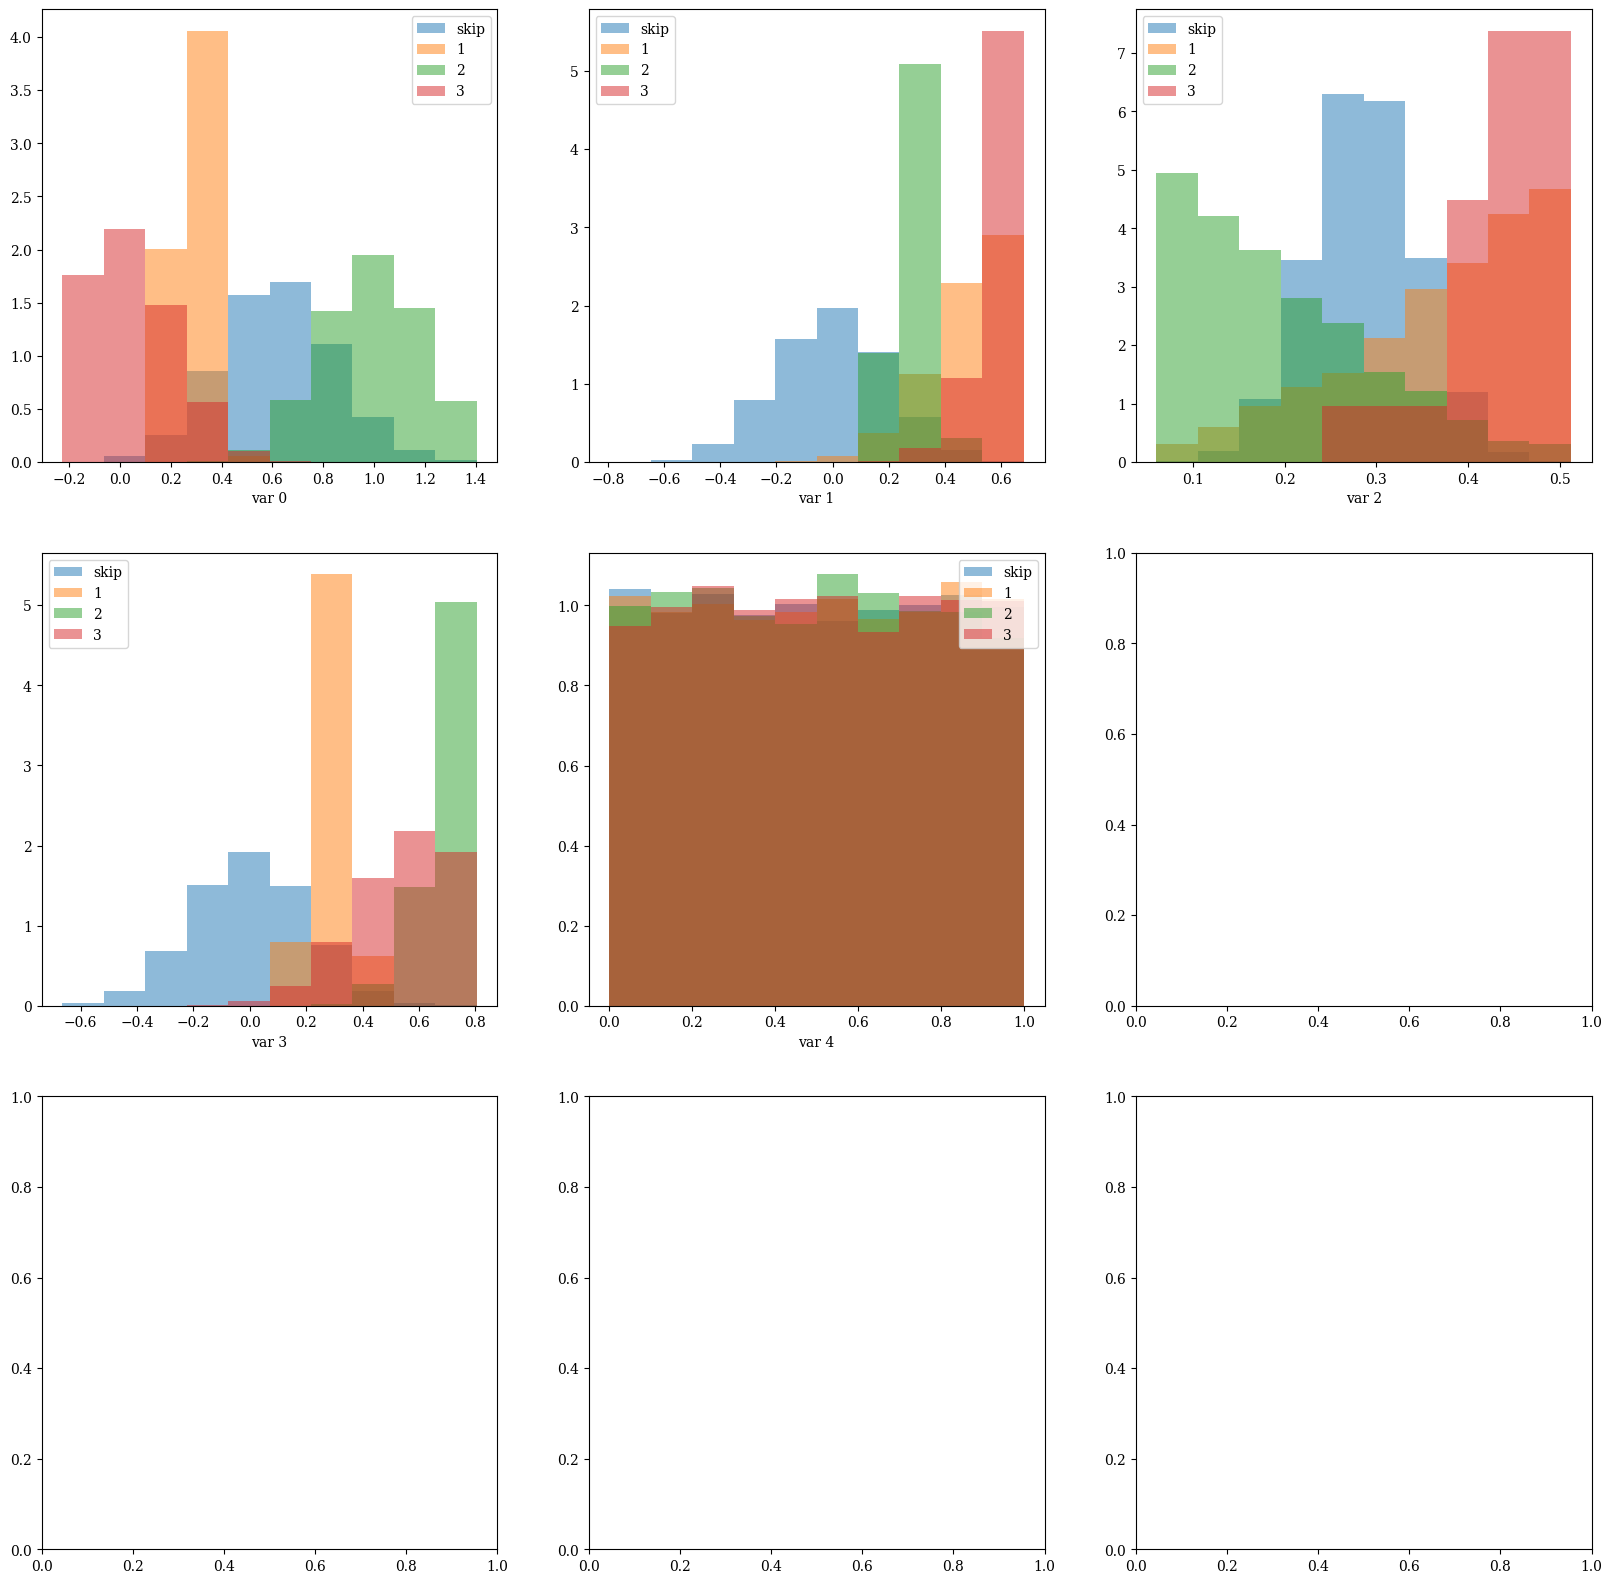

In [4]:
#np.random.seed(1000)
embed_dim=4
nsigs=4
ndisc=4
nrand=1
nj_train   = 10000
nj_valid   = 10000
nj_testy   = 10000
tjds       = datasets.FlatDataset(nsigs,ndisc,nj_train,nj_valid,nj_testy,nrand)
tjds.plot()
torch.save(tjds,'flat_data.pt')

/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['classifier'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'shifter' is an insta

Sanity Checking: |                                                                                            …

/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (30) is smaller than the logging interval Trainer(log_eve

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


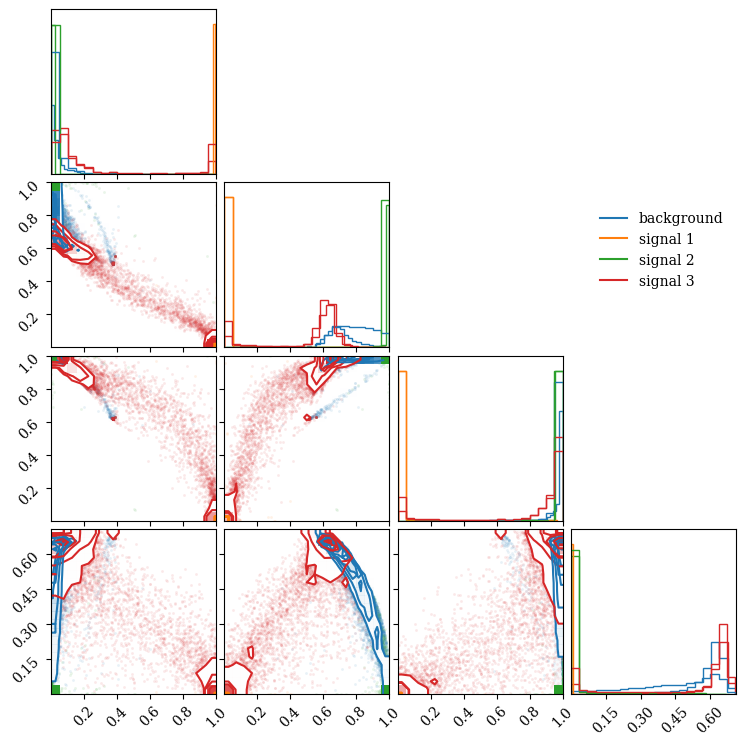

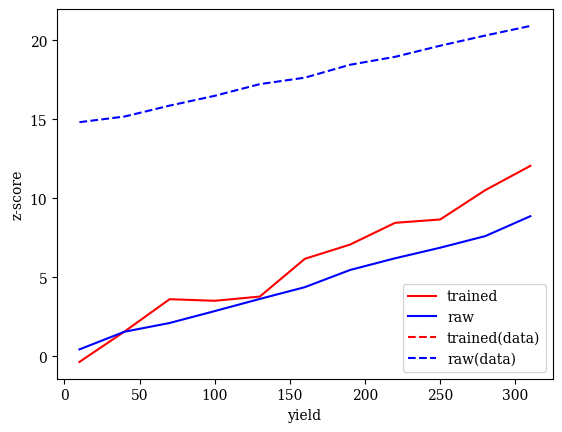

In [16]:
model,o1,o2=tjds.trainQuick(embed_dim=embed_dim,num_epochs=10,temp=0.1)
torch.save(model, "model_baseline.pth")

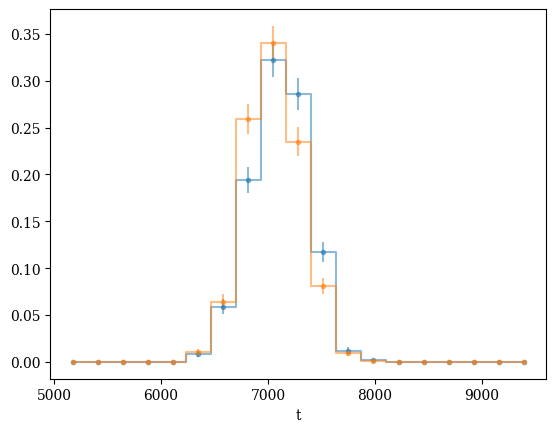

z1 0.5376490622813583 + 0.6251788330015032 - 0.4500334357975354
z2 0.005618529020738082 + 0.09056322072925081 - -0.07940732242982616
zemp 0.22497335831381135 + 0.27736094542673945 - 0.17319642535867127 0.411 0.020248516666276223


/Users/philipharris/Dropbox/Physics/8S50_2022/test3/phlab-neurips25/experiments/toyjet/../../data/data_utils.py:691: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(x,tsvals/np.sum(tsvals),yerr=np.sqrt(tsvals)/np.sum(tsvals),alpha=0.5,marker='.',drawstyle='steps-mid',label="Sig+bkg")


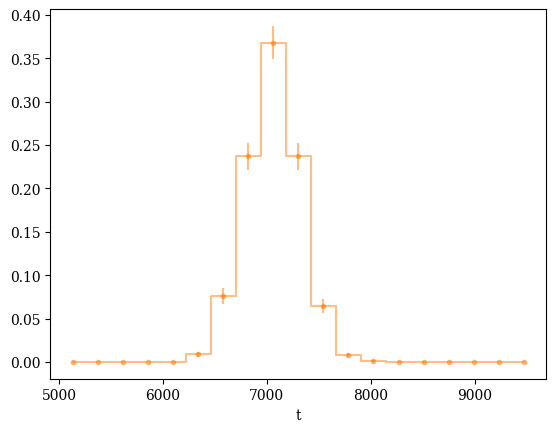

z1 inf + inf - inf
z2 0.005609356719305173 + 0.08987677418769588 - -0.07873780033642962
zemp 3.090232306167813 + inf - 2.878161739095483 0.001 0.0009999999999999998


(inf, 3.090232306167813)

In [17]:
#pretraining
with torch.no_grad():
    output_train  = tjds.model.encoder(tjds.train_data.float())
    output        = tjds.model.encoder(tjds.test_data.float())
    output1       = tjds.model.encoder(tjds.true_data.float())
    #output2       = tjds.model.shifter(output1) ### If we correct data relative to MC
    
#print(output1[0],output2[0])
#tjds.cornerQuick(output,output1,tjds.test_labels,tjds.test_labels)
#tjds.cornerQuick(output1,output1,tjds.true_labels,tjds.true_labels)
#tjds.cornerQuick(output1,output2,tjds.true_labels,tjds.true_labels)
#tjds.cornerQuick(output,output,tjds.test_labels,tjds.test_labels)
#tjds.zscoreplot(output,output1,tjds.test_labels,tjds.test_labels,tjds.test_data,tjds.true_data)
#dutils.z_yield(output1,tjds.true_labels,output,tjds.test_labels,(nsigs-1),iNbins=1,ntoys=100,iNb=10000,iNr=20000,plot=True)
dutils.run_toy(10, 10000, 20000,output,tjds.test_labels,output,tjds.test_labels,(nsigs-1),ntoys=1000,plot=True)
dutils.run_toy(10, 10000, 20000,output1,tjds.true_labels,output,tjds.test_labels,(nsigs-1),ntoys=1000,plot=True)





In [18]:
#model = torch.load("model_baseline.pth")
from collections import defaultdict
from models.networks import MLP
with torch.no_grad(): 
    c1=torch.nn.functional.softmax(model.classifier(o1)[tjds.train_labels != (nsigs-1)]).numpy()
    c2=torch.nn.functional.softmax(model.classifier(o2)[tjds.true_labels  != (nsigs-1)]).numpy()

#plt.hist(c1[:,1],alpha=0.5)
#plt.hist(c2[:,1],alpha=0.5)
#plt.yscale('log')
#plt.show()

embed_dim=4
cut_threshold = 0.2 # threshold to cut on for training subsample; assigned class prob must be > threshold
maxval1=np.max(c1,1)
maxval2=np.max(c2,1)
cut_mctr   = tjds.train_data  [tjds.train_labels != (nsigs-1)][maxval1 > cut_threshold]
cut_labelm = tjds.train_labels[tjds.train_labels != (nsigs-1)][maxval1 > cut_threshold]
cut_mc     = dutils.GenericDataset(cut_mctr, cut_labelm)

cut_data   = tjds.true_data  [tjds.true_labels != (nsigs-1)][maxval2 > cut_threshold]
#cut_labeld = tjds.true_labels[tjds.true_labels != (nsigs-1)][maxval2 > cut_threshold]
cut_labeld = torch.tensor(np.argmax(c2,axis=1))[maxval2 > cut_threshold]
cut_ds     = dutils.GenericDataset(cut_data, cut_labeld)

#tot_c = torch.cat((cut_mctr,cut_data))
#tot_l = torch.cat((cut_labelm,cut_labeld+3))
#tot_ds     = dutils.GenericDataset(tot_c, tot_l)
merger=dutils.ConcatWithLabels([cut_mc,cut_ds],[0,1])
labels = merger._labels
batch_size = 1000
num_classes = 2#(nsigs-1)*2
sampler = dutils.BalancedBatchSampler(labels, batch_size, num_classes)
train_loader   = DataLoader(merger,num_workers=2,batch_sampler=sampler)

tensor([0., 0., 0.,  ..., 1., 1., 1.])


/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_71834/3268161496.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c1=torch.nn.functional.softmax(model.classifier(o1)[tjds.train_labels != (nsigs-1)]).numpy()
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_71834/3268161496.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c2=torch.nn.functional.softmax(model.classifier(o2)[tjds.true_labels  != (nsigs-1)]).numpy()


Epoch [1/15], Loss: 8.1342
Epoch [2/15], Loss: 7.6488
Epoch [3/15], Loss: 7.2222
Epoch [4/15], Loss: 7.1183
Epoch [5/15], Loss: 7.4296
Epoch [6/15], Loss: 7.1963
Epoch [7/15], Loss: 7.2206
Epoch [8/15], Loss: 7.2305
Epoch [9/15], Loss: 7.6192
Epoch [10/15], Loss: 7.1557
Epoch [11/15], Loss: 7.8603
Epoch [12/15], Loss: 7.1049
Epoch [13/15], Loss: 7.4373
Epoch [14/15], Loss: 7.2453
Epoch [15/15], Loss: 7.1285


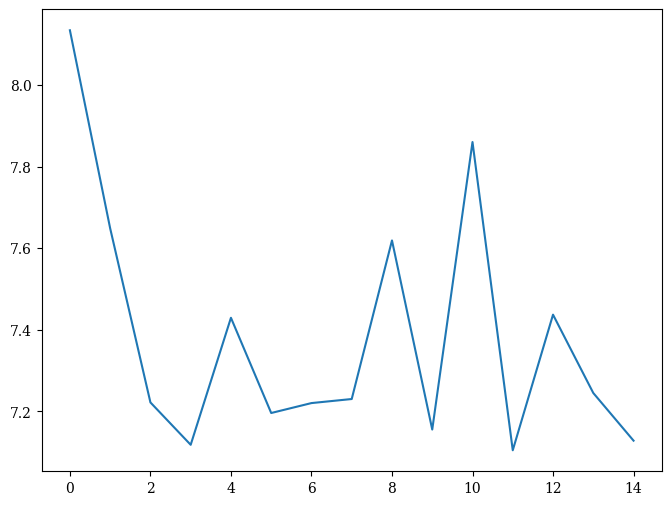

In [19]:
#loaded_model = torch.load("model_baseline.pth")
from models.losses import SupervisedSimCLRLoss
criterion = SupervisedSimCLRLoss(temperature=0.01)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)
dutils.train_generic_datamc(15,train_loader,model,criterion,optimizer,iCorrectData=False)

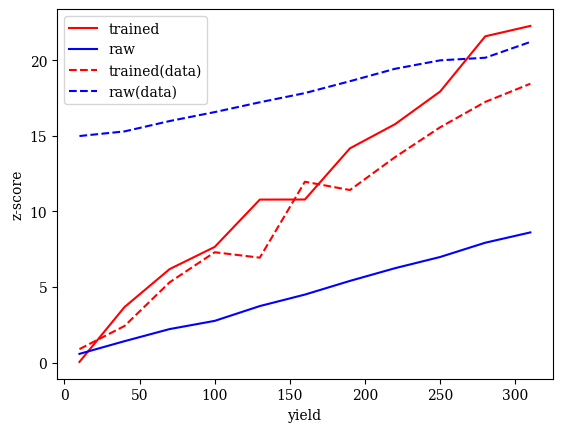

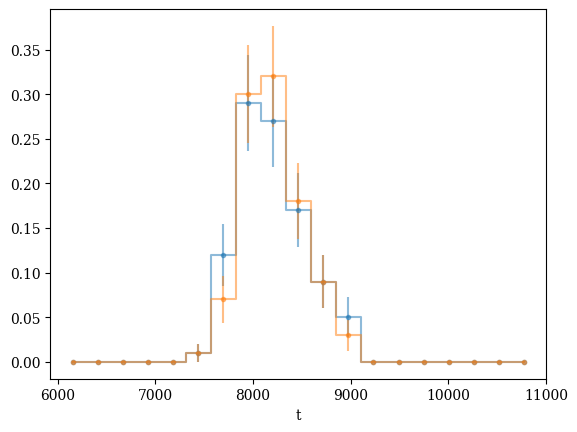

z1 -0.5699237615350637 + -0.23984115421537414 - -0.9011475932552258
z2 0.005199599860144339 + 0.31474429459702447 - -0.3053447467795852
zemp -0.10043372051146988 + 0.0823444232356214 - -0.2866597889092196 0.54 0.07281358514603017


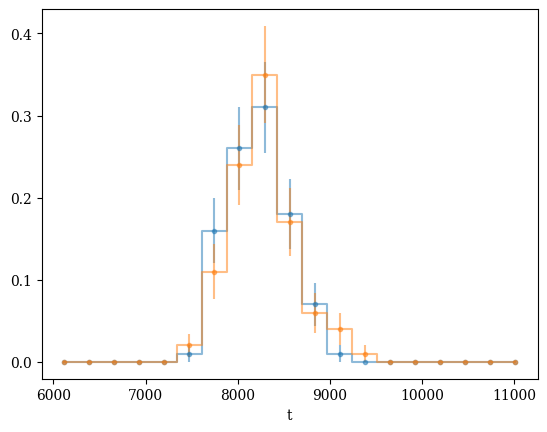

z1 -0.44003712640155973 + -0.1255722363505977 - -0.7555344095731459
z2 0.005187888447413205 + 0.35046579511245746 - -0.34133143916947045
zemp -0.20189347914185074 + -0.011256080577032788 - -0.4002384959819072 0.58 0.07550956836887784


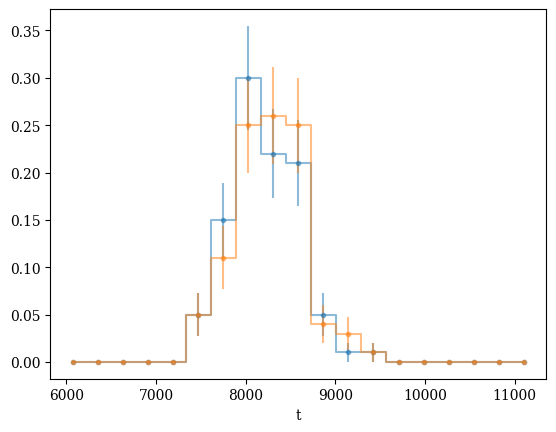

z1 -0.694440463370091 + -0.3235623028196784 - -1.0667584015238265
z2 0.005189727152631083 + 0.3613764054110325 - -0.35231867501080755
zemp -0.1763741647808612 + 0.012144077098682796 - -0.3714388865975616 0.57 0.07484466673004186


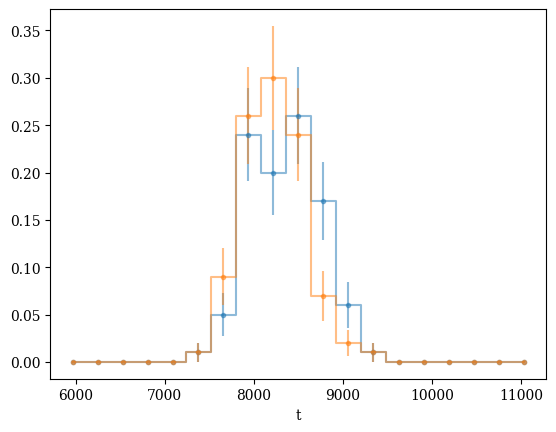

z1 1.0767971186608096 + 1.4447138503759394 - 0.7074771362569023
z2 0.005199605111143088 + 0.3402865786611985 - -0.3310591146739169
zemp 0.3584587932511938 + 0.5220540057173099 - 0.20398237653161952 0.36 0.05918363542992863


(1.0767971186608096, 0.3584587932511938)

In [20]:
#postraining
with torch.no_grad():
    #output_train  = tjds.model.encoder(tjds.train_data.float())
    output        = model.encoder(tjds.test_data.float())
    output1       = model.encoder(tjds.true_data.float())
    output2       = output  + model.shifter(output) ### If we correct data relative to MC
    output3       = output1 + model.shifter(output1) ### If we correct data relative to MC
 
#print(output1[0],output2[0])
#tjds.cornerQuick(output,output1,tjds.test_labels,tjds.test_labels)
#tjds.cornerQuick(output1,output1,tjds.true_labels,tjds.true_labels)
#tjds.cornerQuick(output3,output2,tjds.true_labels,tjds.true_labels)
#tjds.cornerQuick(output2,output,tjds.test_labels,tjds.test_labels)

tjds.zscoreplot(output1,output,tjds.test_labels,tjds.test_labels,tjds.test_data,tjds.true_data)
#dutils.z_yield(output1,tjds.true_labels,output,tjds.test_labels,(nsigs-1),iNbins=1,ntoys=100,iNb=10000,iNr=20000,plot=True)

dutils.run_toy(1, 10000, 20000,output2,tjds.test_labels,output2,tjds.test_labels,(nsigs-1),ntoys=100,plot=True)
dutils.run_toy(1, 10000, 20000,output3,tjds.true_labels,output2,tjds.test_labels,(nsigs-1),ntoys=100,plot=True)

dutils.run_toy(1, 10000, 20000,output,tjds.test_labels,output,tjds.test_labels,(nsigs-1),ntoys=100,plot=True)
dutils.run_toy(1, 10000, 20000,output1,tjds.true_labels,output,tjds.test_labels,(nsigs-1),ntoys=100,plot=True)



